<a href="https://colab.research.google.com/github/pathikritsyam/ECTA/blob/main/ANN/ANN_%26_GA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
# Solo configurar GPU si está disponible
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print(f"GPU disponible: {physical_devices[0]}")
else:
    print("No hay GPU disponible. Usando CPU.")

No hay GPU disponible. Usando CPU.


# 04.02 - Exploratory Data Analysis & ANN & Genetic Algorithm - Full Notebook

## Imports & setup

In [3]:
import pathlib
import datetime
from os import PathLike
from typing import Union

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import palettable
import seaborn as sns
%matplotlib inline

PROJECT_DIR = pathlib.Path.cwd().parent.resolve()
CLEAN_DATA_DIR = PROJECT_DIR / 'data' / '05-clean'

plt.style.use('grayscale')
# Custom Overrides to grayscale
params = {'legend.fontsize': 'x-large',
          'lines.linewidth': 0.75,
      'figure.figsize': (15, 7),
          'grid.color': 'white',
          'axes.axisbelow': False,
          'axes.grid': True,
          'axes.grid.axis': 'y',
     'axes.labelsize': 'x-large',
     'axes.titlesize':'xx-large',
     'xtick.labelsize':'x-large',
     'ytick.labelsize':'x-large'}
plt.rcParams.update(params)
figsize=(15,7)

## Load Data

In [4]:
dtypes = {'Temperature': np.float64, 'Dewpoint Temp':np.float64, 'Relative Humidity':np.float64,
          'Wind Speed': np.float64, 'Visibility': np.float64, 'Pressure': np.float64,
          'Wind_Chill': np.float64,
         'Hour_of_Day': np.float64, 'Year': np.float64, 'Month': np.float64,
         'Day_Of_Week': np.float64, 'Day_of_Year': np.float64, 'Week_Of_Year': np.float64,
          'Quarter': np.float64, 'Stat_Hol': np.float64}


df_orig = pd.read_excel("../data/ECTA 2023 Dataset.xlsx")

# Convert Date column to datetime with dayfirst=True and handle errors
df_orig['Date'] = pd.to_datetime(df_orig['Date'], dayfirst=True, errors='coerce')

# Drop rows with invalid dates (NaT)
df_orig = df_orig.dropna(subset=['Date'])

# Set Date as index
df_orig.set_index('Date', inplace=True)

# Apply dtypes to relevant columns
for col, dtype in dtypes.items():
    if col in df_orig.columns:
        df_orig[col] = df_orig[col].astype(dtype)

daymapper = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
weekdaymapper = {0: 'Weekday', 1: 'Weekday', 2: 'Weekday', 3: 'Weekday', 4: 'Weekday',
                 5: 'Weekend', 6: 'Weekend'}
df_orig['dayofweek'] = df_orig['Day_Of_Week'].map(daymapper)
df_orig['daytype'] = df_orig['Day_Of_Week'].map(weekdaymapper)

print(f"Dataset loaded successfully. Shape: {df_orig.shape}")

Dataset loaded successfully. Shape: (96360, 18)


In [5]:
df_orig.head()

,Time,Year,Quarter,Month,Week_Of_Year,Day_of_Year,Day_Of_Week,Stat_Hol,Hour_of_Day,Relative Humidity,Wind Speed,Visibility,Pressure,Wind_Chill,Dewpoint Temp,Temperature,dayofweek,daytype
Date,,,,,,,,,,,,,,,,,,
2010-01-01,00:00:00,2010.0,1.0,1.0,53.0,1.0,4.0,1.0,0.0,76.0,26.0,25.0,99.26,-18.0,-12.7,-9.3,Fri,Weekday
2010-01-01,01:00:00,2010.0,1.0,1.0,53.0,1.0,4.0,1.0,1.0,76.0,26.0,25.0,99.26,-18.0,-12.8,-9.3,Fri,Weekday
2010-01-01,02:00:00,2010.0,1.0,1.0,53.0,1.0,4.0,1.0,2.0,74.0,26.0,25.0,99.29,-18.0,-13.4,-9.6,Fri,Weekday
2010-01-01,03:00:00,2010.0,1.0,1.0,53.0,1.0,4.0,1.0,3.0,72.0,22.0,25.0,99.35,-18.0,-13.9,-9.8,Fri,Weekday
2010-01-01,04:00:00,2010.0,1.0,1.0,53.0,1.0,4.0,1.0,4.0,74.0,32.0,24.1,99.42,-19.0,-13.5,-9.7,Fri,Weekday


In [6]:
df_orig.tail()

,Time,Year,Quarter,Month,Week_Of_Year,Day_of_Year,Day_Of_Week,Stat_Hol,Hour_of_Day,Relative Humidity,Wind Speed,Visibility,Pressure,Wind_Chill,Dewpoint Temp,Temperature,dayofweek,daytype
Date,,,,,,,,,,,,,,,,,,
2020-12-31,19:00:00,2020.0,4.0,12.0,53.0,365.0,3.0,0.0,19.0,94.0,9.0,16.1,99.21,-11.702041,0.8,1.6,Thu,Weekday
2020-12-31,20:00:00,2020.0,4.0,12.0,53.0,365.0,3.0,0.0,20.0,95.0,9.0,11.3,99.21,-11.702041,0.4,1.1,Thu,Weekday
2020-12-31,21:00:00,2020.0,4.0,12.0,53.0,365.0,3.0,0.0,21.0,97.0,7.0,9.7,99.20,-11.702041,0.6,1.0,Thu,Weekday
2020-12-31,22:00:00,2020.0,4.0,12.0,53.0,365.0,3.0,0.0,22.0,97.0,7.0,9.7,99.20,-11.702041,0.5,0.9,Thu,Weekday
2020-12-31,23:00:00,2020.0,4.0,12.0,53.0,365.0,3.0,0.0,23.0,96.0,7.0,8.0,99.19,-11.702041,0.1,0.6,Thu,Weekday


In [7]:
df_orig.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 96360 entries, 2010-01-01 to 2020-12-31
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Time               96360 non-null  object 
 1   Year               96360 non-null  float64
 2   Quarter            96360 non-null  float64
 3   Month              96360 non-null  float64
 4   Week_Of_Year       96360 non-null  float64
 5   Day_of_Year        96360 non-null  float64
 6   Day_Of_Week        96360 non-null  float64
 7   Stat_Hol           96360 non-null  float64
 8   Hour_of_Day        96360 non-null  float64
 9   Relative Humidity  96360 non-null  float64
 10  Wind Speed         96360 non-null  float64
 11  Visibility         96360 non-null  float64
 12  Pressure           96360 non-null  float64
 13  Wind_Chill         96360 non-null  float64
 14  Dewpoint Temp      96360 non-null  float64
 15  Temperature        96360 non-null  float64
 16  dayof

In [8]:
for col in df_orig.columns:
    print(col)

Time
Year
Quarter
Month
Week_Of_Year
Day_of_Year
Day_Of_Week
Stat_Hol
Hour_of_Day
Relative Humidity
Wind Speed
Visibility
Pressure
Wind_Chill
Dewpoint Temp
Temperature
dayofweek
daytype


In [9]:
df_orig['Year'].value_counts()

Year
2010.0    8760
2011.0    8760
2012.0    8760
2013.0    8760
2014.0    8760
2015.0    8760
2016.0    8760
2017.0    8760
2018.0    8760
2019.0    8760
2020.0    8760
Name: count, dtype: int64

### Data for Every Hour in 2008

In [10]:
pd.set_option('display.max_columns', 100)

df2018 = df_orig.loc['2010':'2015', :].copy(deep=True)
df2018.head()

,Time,Year,Quarter,Month,Week_Of_Year,Day_of_Year,Day_Of_Week,Stat_Hol,Hour_of_Day,Relative Humidity,Wind Speed,Visibility,Pressure,Wind_Chill,Dewpoint Temp,Temperature,dayofweek,daytype
Date,,,,,,,,,,,,,,,,,,
2010-01-01,00:00:00,2010.0,1.0,1.0,53.0,1.0,4.0,1.0,0.0,76.0,26.0,25.0,99.26,-18.0,-12.7,-9.3,Fri,Weekday
2010-01-01,01:00:00,2010.0,1.0,1.0,53.0,1.0,4.0,1.0,1.0,76.0,26.0,25.0,99.26,-18.0,-12.8,-9.3,Fri,Weekday
2010-01-01,02:00:00,2010.0,1.0,1.0,53.0,1.0,4.0,1.0,2.0,74.0,26.0,25.0,99.29,-18.0,-13.4,-9.6,Fri,Weekday
2010-01-01,03:00:00,2010.0,1.0,1.0,53.0,1.0,4.0,1.0,3.0,72.0,22.0,25.0,99.35,-18.0,-13.9,-9.8,Fri,Weekday
2010-01-01,04:00:00,2010.0,1.0,1.0,53.0,1.0,4.0,1.0,4.0,74.0,32.0,24.1,99.42,-19.0,-13.5,-9.7,Fri,Weekday


In [11]:
df2018.describe()

,Year,Quarter,Month,Week_Of_Year,Day_of_Year,Day_Of_Week,Stat_Hol,Hour_of_Day,Relative Humidity,Wind Speed,Visibility,Pressure,Wind_Chill,Dewpoint Temp,Temperature
count,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000
mean,2012.500000,2.509589,6.526027,26.612785,183.279452,3.000000,0.027397,11.500000,69.163271,16.145824,19.699739,99.557248,-11.719478,3.145761,8.952211
std,1.707841,1.116778,3.447884,15.063535,105.446198,1.999106,0.163240,6.922252,16.035276,9.924293,7.205295,0.753795,2.883564,10.149820,10.881082
min,2010.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,17.000000,0.000000,0.000000,95.910000,-38.000000,-32.000000,-24.600000
25%,2011.000000,2.000000,4.000000,14.000000,92.000000,1.000000,0.000000,5.750000,58.000000,9.000000,16.100000,99.100000,-11.702041,-4.400000,0.800000
50%,2012.500000,3.000000,7.000000,27.000000,183.000000,3.000000,0.000000,11.500000,70.000000,15.000000,24.100000,99.590000,-11.702041,3.500000,9.000000
75%,2014.000000,4.000000,10.000000,40.000000,275.000000,5.000000,0.000000,17.250000,81.000000,22.000000,24.100000,100.050000,-11.702041,11.500000,18.000000
max,2015.000000,4.000000,12.000000,53.000000,366.000000,6.000000,1.000000,23.000000,100.000000,76.000000,40.200000,102.220000,-1.000000,25.300000,37.200000


In [12]:
import sklearn
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [13]:
df2018.columns

Index(['Time', 'Year', 'Quarter', 'Month', 'Week_Of_Year', 'Day_of_Year',
       'Day_Of_Week', 'Stat_Hol', 'Hour_of_Day', 'Relative Humidity',
       'Wind Speed', 'Visibility', 'Pressure', 'Wind_Chill', 'Dewpoint Temp',
       'Temperature', 'dayofweek', 'daytype'],
      dtype='object')

In [14]:
features_train=df2018[['Temperature', 'Dewpoint Temp', 'Relative Humidity','Wind Speed', 'Visibility', 'Pressure','Hour_of_Day','Month','Day_Of_Week', 'Day_of_Year', 'Week_Of_Year','Quarter']]
features_train
scaler=StandardScaler()
Train=scaler.fit_transform(np.array(features_train))
Train

array([[-1.67744202, -1.56120128,  0.42635964, ..., -1.72866533,
         1.75174456, -1.35174944],
       [-1.67744202, -1.57105377,  0.42635964, ..., -1.72866533,
         1.75174456, -1.35174944],
       [-1.70501307, -1.63016868,  0.30163344, ..., -1.72866533,
         1.75174456, -1.35174944],
       ...,
       [ 0.03196304,  0.47826318,  1.42416922, ...,  1.73284851,
         1.75174456,  1.33457658],
       [ 0.05953409,  0.45855821,  1.23707992, ...,  1.73284851,
         1.75174456,  1.33457658],
       [-0.03236941,  0.14327868,  0.42635964, ...,  1.73284851,
         1.75174456,  1.33457658]], shape=(52560, 12))

In [15]:
cmatrix = features_train.corr()
round(cmatrix, ndigits=5)

,Temperature,Dewpoint Temp,Relative Humidity,Wind Speed,Visibility,Pressure,Hour_of_Day,Month,Day_Of_Week,Day_of_Year,Week_Of_Year,Quarter
Temperature,1.00000,0.93431,-0.21288,-0.10215,0.01799,-0.16034,0.10574,0.27913,0.00027,0.27583,0.27105,0.28300
Dewpoint Temp,0.93431,1.00000,0.14335,-0.17904,-0.17072,-0.25192,0.01612,0.32763,-0.00173,0.32453,0.31979,0.32933
Relative Humidity,-0.21288,0.14335,1.00000,-0.21421,-0.57124,-0.26503,-0.25246,0.12393,-0.00415,0.12447,0.12469,0.12003
Wind Speed,-0.10215,-0.17904,-0.21421,1.00000,0.12523,-0.28567,0.13531,-0.06306,0.01699,-0.06484,-0.06787,-0.06118
Visibility,0.01799,-0.17072,-0.57124,0.12523,1.00000,0.27541,0.05450,0.01978,-0.00943,0.02087,0.01977,0.01680
Pressure,-0.16034,-0.25192,-0.26503,-0.28567,0.27541,1.00000,-0.00851,0.00887,0.00521,0.01034,0.01428,0.00476
Hour_of_Day,0.10574,0.01612,-0.25246,0.13531,0.05450,-0.00851,1.00000,0.00000,-0.00000,0.00000,0.00000,0.00000
Month,0.27913,0.32763,0.12393,-0.06306,0.01978,0.00887,0.00000,1.00000,-0.00033,0.99650,0.96873,0.97136
Day_Of_Week,0.00027,-0.00173,-0.00415,0.01699,-0.00943,0.00521,-0.00000,-0.00033,1.00000,-0.00012,0.00067,-0.00061
Day_of_Year,0.27583,0.32453,0.12447,-0.06484,0.02087,0.01034,0.00000,0.99650,-0.00012,1.00000,0.97006,0.96820


In [16]:
pd.set_option('display.max_columns', 100)

dftest = df_orig.loc['2016', :].copy(deep=True)
# dftest.head()
features_test= dftest[['Temperature', 'Dewpoint Temp', 'Relative Humidity','Wind Speed', 'Visibility', 'Pressure','Hour_of_Day','Month','Day_Of_Week', 'Day_of_Year', 'Week_Of_Year','Quarter']]
Test=scaler.fit_transform(np.array(features_test))
Test

array([[-0.29221725, -0.24964412,  0.05871516, ..., -1.72731195,
         1.75505084, -1.35174944],
       [-0.41798174, -0.45273457, -0.18705944, ..., -1.72731195,
         1.75505084, -1.35174944],
       [-0.56051484, -0.60966809, -0.18705944, ..., -1.72731195,
         1.75505084, -1.35174944],
       ...,
       [-1.21449021, -0.97892345,  1.04181358, ...,  1.72731195,
         1.68863367,  1.33457658],
       [-1.19772161, -1.0066176 ,  0.85748262, ...,  1.72731195,
         1.68863367,  1.33457658],
       [-1.22287451, -0.99738622,  0.98036993, ...,  1.72731195,
         1.68863367,  1.33457658]], shape=(8760, 12))

In [17]:
# x_train=Train[:,:-1]
# y_train=Train[:,-1]
# x_test=Test[:,:-1]
# y_test=Test[:,-1]

In [18]:
print(Train[0,:-1])
print(Train[1,:-1])
print(Train[2,:-1])
print(np.concatenate((Train[0,:-1], Train[1,:-1], Train[2,:-1])))

[-1.67744202 -1.56120128  0.42635964  0.99294424  0.7356133  -0.39433948
 -1.66132477 -1.60274527  0.50022847 -1.72866533  1.75174456]
[-1.67744202 -1.57105377  0.42635964  0.99294424  0.7356133  -0.39433948
 -1.51686175 -1.60274527  0.50022847 -1.72866533  1.75174456]
[-1.70501307 -1.63016868  0.30163344  0.99294424  0.7356133  -0.35454046
 -1.37239873 -1.60274527  0.50022847 -1.72866533  1.75174456]
[-1.67744202 -1.56120128  0.42635964  0.99294424  0.7356133  -0.39433948
 -1.66132477 -1.60274527  0.50022847 -1.72866533  1.75174456 -1.67744202
 -1.57105377  0.42635964  0.99294424  0.7356133  -0.39433948 -1.51686175
 -1.60274527  0.50022847 -1.72866533  1.75174456 -1.70501307 -1.63016868
  0.30163344  0.99294424  0.7356133  -0.35454046 -1.37239873 -1.60274527
  0.50022847 -1.72866533  1.75174456]


In [19]:
np.stack([Train[j,-1] for j in range(0, 12)])

array([-1.35174944, -1.35174944, -1.35174944, -1.35174944, -1.35174944,
       -1.35174944, -1.35174944, -1.35174944, -1.35174944, -1.35174944,
       -1.35174944, -1.35174944])

In [20]:
print(Train.shape)
print(Train[2:].shape)
x_train = np.array([np.concatenate((Train[i-2], Train[i-1], Train[i])) for i in range(2, len(Train)-24)])
x_test = np.array([np.concatenate((Test[i-2], Test[i-1], Test[i])) for i in range(2, len(Test)-24)])[:500]
print(f'x_train.shape: {x_train.shape} x_test.shape: {x_test.shape}')
y_train = np.array([np.stack([Train[i+j+1,-1] for j in range(0, 24)]) for i in range(2, len(Train)-24)])
y_test = np.array([np.stack([Test[i+j+1,-1] for j in range(0, 24)]) for i in range(2, len(Test)-24)])[:500]
print(f'y_train.shape: {y_train.shape} y_test.shape: {y_test.shape}')

(52560, 12)
(52558, 12)
x_train.shape: (52534, 36) x_test.shape: (500, 36)
y_train.shape: (52534, 24) y_test.shape: (500, 24)


##Genetic Algorithm Concepts

In [21]:
from random import choice
from random import uniform
from numpy.random import randint
import random

In [22]:
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras import regularizers
from sklearn import metrics
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error


In [23]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25)

In [24]:
def ANN_model(lr, batch_sz, ep):
  model = Sequential()
  # Defining the input layer
  # model.add(Dense(units=f1, input_dim=x_train.shape[1], kernel_initializer='normal', activation=a1))
  model.add(Dense(units=36, input_dim=x_train.shape[1], kernel_initializer='normal', activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-5), bias_regularizer=regularizers.L2(1e-5), activity_regularizer=regularizers.L2(1e-5)))


  # Defining the  two hidden layers
  # model.add(Dense(units=f2, kernel_initializer='normal', activation=a2))
  model.add(Dense(units=64, kernel_initializer='normal', activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-5), bias_regularizer=regularizers.L2(1e-5), activity_regularizer=regularizers.L2(1e-5)))
  model.add(Dense(units=36, kernel_initializer='normal', activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-5), bias_regularizer=regularizers.L2(1e-5), activity_regularizer=regularizers.L2(1e-5)))



  # Defining the output layer of the model
  model.add(Dense(24, kernel_initializer='normal',activation='linear'))

  # if op == "sgd":
  #   op = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.5, decay=0.009, nesterov=True)

  # elif op == "adamax":
  #   op = tf.keras.optimizers.Adamax(learning_rate=lr, beta_1=0.9,beta_2=0.999,epsilon=1e-07)

  # elif op == "adam":
  #   op = tf.keras.optimizers.Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

  # elif op == "adagrad":
  #   op = tf.keras.optimizers.Adagrad(learning_rate=lr, initial_accumulator_value=0.1,epsilon=1e-07)

  # else:
  #   op == tf.keras.optimizers.Nadam(learning_rate=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

  # Compiling the model
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.01,decay_steps=10000,decay_rate=0.9)
  optimiser = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

  # Compiling the model
  model.compile(loss='mean_squared_error', optimizer='Adam')

  # Early_Stopping
  callback = [EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5, min_delta=0.0001),
              # ModelCheckpoint(filepath="fname.hdf5", save_weights_only=True, monitor='val_loss', mode='max', save_best_only=True)
              ]

  # Fitting the ANN to the Training set
  model.fit(x_train, y_train, batch_size = batch_sz, epochs = ep,validation_data=(x_val,y_val),callbacks=[callback],verbose=0)

  return model

In [25]:
# Fitness evaluation metric: Classification Accuracy
from keras.losses import mean_squared_error as MSE
from keras.losses import MeanAbsoluteError
def fitness_evaluation(model):
  #mean_absolute_percentage_error = tf.keras.losses.MeanAbsolutePercentageError()
  #metrics = kl(y_test, model.predict(x_test)).numpy()
  #metrics = mean_absolute_percentage_error(y_test, model.predict(x_test)).numpy()
  MSE = tf.keras.losses.MeanSquaredError()
  metrics = MSE(y_test, model.predict(x_test)).numpy().mean()
  print(f"metrics:{metrics}")
  return metrics

In [26]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [27]:
# Genetic Algorithm Functions

# Hyperparameter ranges
batch_size_list = [8, 12, 16, 20, 24, 80, 200, 240]
epoch_list = [8, 200, 500, 527, 652, 860, 1000]
learning_rate_list = [0.75, 0.5, 0.25, 0.1, 0.075, 0.05, 0.025, 0.01, 0.0075, 0.005, 0.0025, 0.001, 0.0005, 0.0001]

def generate_population(population_size):
    """Generate initial population of chromosomes"""
    population = []
    for _ in range(population_size):
        chromosome = {
            "lr": np.random.choice(learning_rate_list),
            "batch_sz": np.random.choice(batch_size_list),
            "ep": np.random.choice(epoch_list)
        }
        population.append(chromosome)
    return population

def selection(population_fitness):
    """Roulette Wheel Selection"""
    # Convert fitness to selection probability (lower is better, so invert)
    fitness_array = np.array(population_fitness)
    # Invert fitness (lower error is better)
    inverted_fitness = 1.0 / (fitness_array + 1e-10)
    # Normalize to probabilities
    probabilities = inverted_fitness / inverted_fitness.sum()

    # Select two parents
    parent_indices = np.random.choice(len(population_fitness), size=2, replace=False, p=probabilities)
    return parent_indices

def crossover(parent1, parent2):
    """Uniform crossover between two parents"""
    child1 = {}
    child2 = {}

    for key in parent1.keys():
        if np.random.rand() < 0.5:
            child1[key] = parent1[key]
            child2[key] = parent2[key]
        else:
            child1[key] = parent2[key]
            child2[key] = parent1[key]

    return [child1, child2]

def mutation(chromosome, mutation_rate=0.3):
    """Mutate chromosome with given probability"""
    mutated = chromosome.copy()

    if np.random.rand() < mutation_rate:
        mutated["lr"] = np.random.choice(learning_rate_list)

    if np.random.rand() < mutation_rate:
        mutated["batch_sz"] = np.random.choice(batch_size_list)

    if np.random.rand() < mutation_rate:
        mutated["ep"] = np.random.choice(epoch_list)

    return mutated

print("Genetic Algorithm functions defined successfully!")


Genetic Algorithm functions defined successfully!


In [32]:
# Defining the list of hyper parameters to try
batch_sz=[8,12,20,24]
ep= [1000]
lr=[0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]

import pandas as pd
SearchResultsData=pd.DataFrame(columns=['TrialNumber', 'Parameters',"learning_rate","MAPE"])

# initializing trials
TrialNumber=0
for batch_size_trial in batch_sz:
  for epochs_trial in ep:
    for learning_rate in lr:
      TrialNumber+=1
      model = Sequential()
      # Defining the input layer
      model.add(Dense(units=36, input_dim=x_train.shape[1], kernel_initializer='normal', activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-5), bias_regularizer=regularizers.L2(1e-5), activity_regularizer=regularizers.L2(1e-5)))

      # Defining the  two hidden layers
      model.add(Dense(units=64, kernel_initializer='normal', activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-5), bias_regularizer=regularizers.L2(1e-5), activity_regularizer=regularizers.L2(1e-5)))
      model.add(Dense(units=36, kernel_initializer='normal', activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-5), bias_regularizer=regularizers.L2(1e-5), activity_regularizer=regularizers.L2(1e-5)))

      # Defining the output layer of the model
      model.add(Dense(24, kernel_initializer='normal',activation='linear'))

      # Compiling the model
      lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.01,decay_steps=10000,decay_rate=0.9)
      optimiser = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

      # Compiling the model
      model.compile(loss='mean_squared_error', optimizer='Adam')

      # Early_Stopping
      callback = [EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5, min_delta=0.0001)]
      
      # Fitting the ANN to the Training set
      model.fit(x_train, y_train, batch_size=batch_size_trial, epochs=epochs_trial, validation_data=(x_val, y_val), callbacks=[callback], verbose=0)
      MAPE = mean_absolute_percentage_error(y_test, model.predict(x_test, verbose=0))
      
      # printing the results of the current iteration
      print(TrialNumber, 'Parameters:','batch_size:', batch_sz, 'epochs:',ep,"lr:", learning_rate, "MAPE:", MAPE)
      
      # Use pd.concat instead of append
      new_row = pd.DataFrame(data=[[TrialNumber, str(batch_size_trial)+'-'+str(epochs_trial)+"-"+str(learning_rate),MAPE]], columns=['TrialNumber', 'Parameters', "MAPE"])
      SearchResultsData = pd.concat([SearchResultsData, new_row], ignore_index=True)

SearchResultsData.to_csv("Results.csv")

C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1 Parameters: batch_size: [8, 12, 20, 24] epochs: [1000] lr: 0.5 MAPE: 0.035835363346996316


C:\Users\USER\AppData\Local\Temp\ipykernel_10380\3655684931.py:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  SearchResultsData = pd.concat([SearchResultsData, new_row], ignore_index=True)
C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2 Parameters: batch_size: [8, 12, 20, 24] epochs: [1000] lr: 0.1 MAPE: 0.021138465535629963


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3 Parameters: batch_size: [8, 12, 20, 24] epochs: [1000] lr: 0.05 MAPE: 0.006923094968868919


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4 Parameters: batch_size: [8, 12, 20, 24] epochs: [1000] lr: 0.01 MAPE: 0.017852149253775238


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5 Parameters: batch_size: [8, 12, 20, 24] epochs: [1000] lr: 0.005 MAPE: 0.03618738341373505


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6 Parameters: batch_size: [8, 12, 20, 24] epochs: [1000] lr: 0.001 MAPE: 0.01673962866334207


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7 Parameters: batch_size: [8, 12, 20, 24] epochs: [1000] lr: 0.0005 MAPE: 0.021186489354021665


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8 Parameters: batch_size: [8, 12, 20, 24] epochs: [1000] lr: 0.0001 MAPE: 0.012671535245686502


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9 Parameters: batch_size: [8, 12, 20, 24] epochs: [1000] lr: 0.5 MAPE: 0.0074234785772745475


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10 Parameters: batch_size: [8, 12, 20, 24] epochs: [1000] lr: 0.1 MAPE: 0.02376390477960862


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11 Parameters: batch_size: [8, 12, 20, 24] epochs: [1000] lr: 0.05 MAPE: 0.017054289725446647


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12 Parameters: batch_size: [8, 12, 20, 24] epochs: [1000] lr: 0.01 MAPE: 0.04397657559804285


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13 Parameters: batch_size: [8, 12, 20, 24] epochs: [1000] lr: 0.005 MAPE: 0.02990275085687827


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14 Parameters: batch_size: [8, 12, 20, 24] epochs: [1000] lr: 0.001 MAPE: 0.01967939513580896


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15 Parameters: batch_size: [8, 12, 20, 24] epochs: [1000] lr: 0.0005 MAPE: 0.011333995688978889


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16 Parameters: batch_size: [8, 12, 20, 24] epochs: [1000] lr: 0.0001 MAPE: 0.009139518675012092


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17 Parameters: batch_size: [8, 12, 20, 24] epochs: [1000] lr: 0.5 MAPE: 0.01659082154604105


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18 Parameters: batch_size: [8, 12, 20, 24] epochs: [1000] lr: 0.1 MAPE: 0.04013167069936053


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19 Parameters: batch_size: [8, 12, 20, 24] epochs: [1000] lr: 0.05 MAPE: 0.04710127256083766


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20 Parameters: batch_size: [8, 12, 20, 24] epochs: [1000] lr: 0.01 MAPE: 0.018290278300647153


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21 Parameters: batch_size: [8, 12, 20, 24] epochs: [1000] lr: 0.005 MAPE: 0.016954250973848395


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22 Parameters: batch_size: [8, 12, 20, 24] epochs: [1000] lr: 0.001 MAPE: 0.028007173423254327


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23 Parameters: batch_size: [8, 12, 20, 24] epochs: [1000] lr: 0.0005 MAPE: 0.015177688286370469


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24 Parameters: batch_size: [8, 12, 20, 24] epochs: [1000] lr: 0.0001 MAPE: 0.01948066536038889


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25 Parameters: batch_size: [8, 12, 20, 24] epochs: [1000] lr: 0.5 MAPE: 0.034408983851026385


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26 Parameters: batch_size: [8, 12, 20, 24] epochs: [1000] lr: 0.1 MAPE: 0.022100589649108826


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27 Parameters: batch_size: [8, 12, 20, 24] epochs: [1000] lr: 0.05 MAPE: 0.024986378043768853


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


28 Parameters: batch_size: [8, 12, 20, 24] epochs: [1000] lr: 0.01 MAPE: 0.022489404161233448


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


29 Parameters: batch_size: [8, 12, 20, 24] epochs: [1000] lr: 0.005 MAPE: 0.024603937456358565


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


30 Parameters: batch_size: [8, 12, 20, 24] epochs: [1000] lr: 0.001 MAPE: 0.012065704958340995


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


31 Parameters: batch_size: [8, 12, 20, 24] epochs: [1000] lr: 0.0005 MAPE: 0.018757390548862465


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32 Parameters: batch_size: [8, 12, 20, 24] epochs: [1000] lr: 0.0001 MAPE: 0.028511743840419504


In [33]:
import tensorflow as tf
generations = 2
threshold = 0.001
num_pop = 2
random.seed(10)

population_chrom = generate_population(num_pop)
error_best = []
par_total = []
error_total = []
par_best = []
population = []

import pandas as pd
SearchResultsData=pd.DataFrame(columns=['Generation', 'Parameters',"learning_rate","MAPE"])

for chromosome in population_chrom:
  population.append([chromosome, 100000])

for generation in range(generations):
  population_fitness = []
  per1=[]
  for ind, [chromosome, err] in enumerate(population):
    # a1 = chromosome["a1"]
    # a2 = chromosome["a2"]
    lr = chromosome["lr"]
    batch_sz = chromosome["batch_sz"]
    ep = chromosome["ep"]

    try:
      model = ANN_model(lr, batch_sz, ep)
      error = fitness_evaluation(model)
      par_total.append(chromosome)
      error_total.append(error)
      print("Parameters: ", chromosome)
      print("MSE Fitness Values: ", error)
      metrics = mean_absolute_percentage_error(y_train, model.predict(x_train, verbose=0))
      print("MAPE training: ", metrics)
    except:
      error=100000
      print("Parameters: ", chromosome)
      print("Invalid parameters - Build fail")
      metrics = mean_absolute_percentage_error(y_train, model.predict(x_train, verbose=0))
      print("MAPE Training: ", metrics)

    per1.append(chromosome)
    population_fitness.append(error)
    population[ind][1] = error
  print(f"Population fitness before: {population_fitness}")
  parents_ind = selection(population_fitness)
  parent1 = population[parents_ind[0]][0]
  parent2 = population[parents_ind[1]][0]

  children = crossover(parent1, parent2)
  child1 = mutation(children[0])
  child2 = mutation(children[1])

  population.append([child1, 100000])
  population.append([child2, 100000])
  # print(len(population))
  print("Generation ", generation+1," Outcome: ")
  if min(population_fitness) <= threshold:
    print("Obtained desired error: ", min(population_fitness))
    break
  else:
    print("Minimum error in generation {} : {}".format(generation+1, min(population_fitness)))
    metrics = mean_absolute_percentage_error(y_train, model.predict(x_train, verbose=0))
    print("MAPE: ", metrics)
    min_pop = min(population_fitness)
    c1=population_fitness.index(min_pop)
    # print(c1, len(per1))
    par_best.append(per1[c1])
    error_best.append(min_pop)

  first_max = max([item[1] for item in population])
  first_max_ind = [item[1] for item in population].index(first_max)
  population.remove(population[first_max_ind])
  second_max = max([item[1] for item in population])
  second_max_ind = [item[1] for item in population].index(second_max)
  population.remove(population[second_max_ind])
  print(f"Population fitness after: {population_fitness}\n\n")
  print(generation, 'Parameters:','batch_size:', batch_sz,'-', 'epochs:',ep,"lr:", lr,"MAPE:",min_pop)
  
  # Use pd.concat instead of append
  new_row = pd.DataFrame(data=[[generation, str(batch_sz)+'-'+str(ep)+"-"+str(lr),metrics]], columns=['generation', 'Parameters', "MAPE"])
  SearchResultsData = pd.concat([SearchResultsData, new_row], ignore_index=True)

SearchResultsData.to_csv("Results2.csv")


print(par_total)
print(error_total)
print(par_best)
print(error_best)

C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:0.0016386957140639424
Parameters:  {'lr': np.float64(0.5), 'batch_sz': np.int64(8), 'ep': np.int64(500)}
MSE Fitness Values:  0.0016386957
MAPE training:  0.032762730462883236


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:0.0049708145670592785
Parameters:  {'lr': np.float64(0.0025), 'batch_sz': np.int64(80), 'ep': np.int64(500)}
MSE Fitness Values:  0.0049708146
MAPE training:  0.05425674832195813
Population fitness before: [np.float32(0.0016386957), np.float32(0.0049708146)]
Generation  1  Outcome: 
Minimum error in generation 1 : 0.0016386957140639424
MAPE:  0.05425674832195813
Population fitness after: [np.float32(0.0016386957), np.float32(0.0049708146)]


0 Parameters: batch_size: 80 - epochs: 500 lr: 0.0025 MAPE: 0.0016386957


C:\Users\USER\AppData\Local\Temp\ipykernel_10380\499458237.py:86: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  SearchResultsData = pd.concat([SearchResultsData, new_row], ignore_index=True)
C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:0.003362801158800721
Parameters:  {'lr': np.float64(0.5), 'batch_sz': np.int64(8), 'ep': np.int64(500)}
MSE Fitness Values:  0.0033628012
MAPE training:  0.04514801658414214


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:0.0018363400595262647
Parameters:  {'lr': np.float64(0.0025), 'batch_sz': np.int64(80), 'ep': np.int64(500)}
MSE Fitness Values:  0.0018363401
MAPE training:  0.03420917396250533
Population fitness before: [np.float32(0.0033628012), np.float32(0.0018363401)]
Generation  2  Outcome: 
Minimum error in generation 2 : 0.0018363400595262647
MAPE:  0.03420917396250533
Population fitness after: [np.float32(0.0033628012), np.float32(0.0018363401)]


1 Parameters: batch_size: 80 - epochs: 500 lr: 0.0025 MAPE: 0.0018363401
[{'lr': np.float64(0.5), 'batch_sz': np.int64(8), 'ep': np.int64(500)}, {'lr': np.float64(0.0025), 'batch_sz': np.int64(80), 'ep': np.int64(500)}, {'lr': np.float64(0.5), 'batch_sz': np.int64(8), 'ep': np.int64(500)}, {'lr': np.float64(0.0025), 'batch_sz': np.int64(80), 'ep': np.int64(500)}]
[np.float32(0.0016386957), np.float32(0.0049708146), np.float32(0.0033628012), np.float32(0.0018363401)]
[{'lr': np.float64(0.5), 'batch_sz'

In [34]:
err_ind = error_best.index(min(error_best))
best_chromosome = par_best[err_ind]

In [35]:
error_best.sort()
print(error_best)
print(best_chromosome)

[np.float32(0.0016386957), np.float32(0.0018363401)]
{'lr': np.float64(0.5), 'batch_sz': np.int64(8), 'ep': np.int64(500)}


In [36]:
params = list(best_chromosome.values())

In [37]:
model = ANN_model(params[0], params[1], params[2])
# model = ANN_model(0.001, 12, 500)

C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [38]:
y_test[:, 1].shape

(500,)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


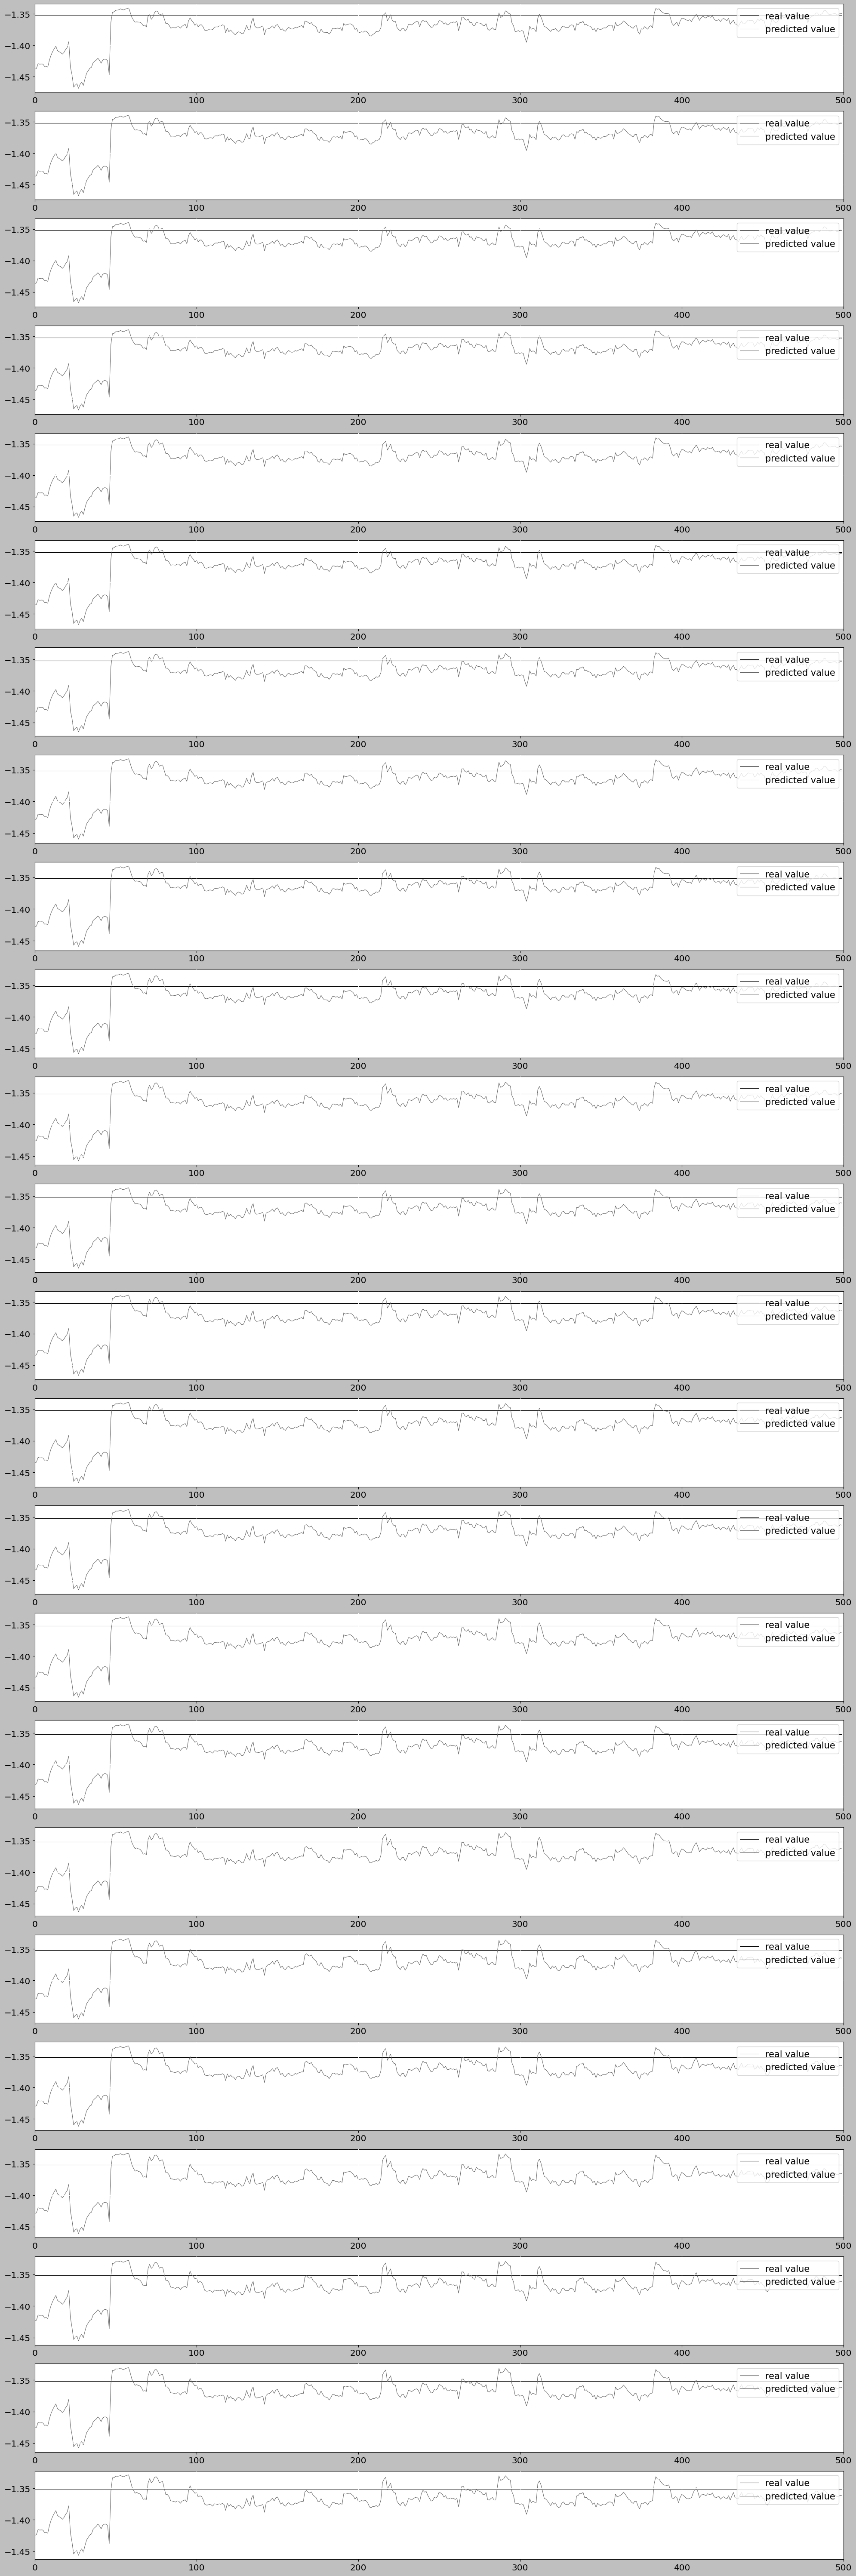

In [39]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(24, 1, figsize=(20, 60))  # Create a figure with 12 subplots
y_predict = model.predict(x_test)
y_predict_array = np.array(y_predict)
# y_predict_array = y_predict_array.reshape(len(y_test), 12)
for i in range(24):
    y_test1 = y_test[:, i]
    y_pre = y_predict_array[:, i]
    # print(y_test1.shape, y_pre.shape)
    draw = pd.concat([pd.DataFrame(y_test[:500, i]), pd.DataFrame(y_pre)], axis=1)
    draw.iloc[:, 0].plot(ax=axs[i])  # Plot y_test value in the corresponding subplot
    draw.iloc[:, 1].plot(ax=axs[i])  # Plot predicted value in the corresponding subplot
    axs[i].legend(('real value', 'predicted value'), loc='upper right', fontsize='15')
    # axs[i].title(f"Test Data vs Predicted after {i+1} hours", fontsize='20')
    axs[i].set_xlim(0, len(y_test1[:]))  # Set the x-axis limits for each subplot

plt.tight_layout()  # Adjust the spacing between subplots
plt.show()


In [43]:
result=pd.read_csv('Results.csv')
result

,Unnamed: 0,TrialNumber,Parameters,learning_rate,MAPE
0,0,1,8-1000-0.5,NaN,0.035835
1,1,2,8-1000-0.1,NaN,0.021138
2,2,3,8-1000-0.05,NaN,0.006923
3,3,4,8-1000-0.01,NaN,0.017852
4,4,5,8-1000-0.005,NaN,0.036187
5,5,6,8-1000-0.001,NaN,0.016740
6,6,7,8-1000-0.0005,NaN,0.021186
7,7,8,8-1000-0.0001,NaN,0.012672
8,8,9,12-1000-0.5,NaN,0.007423
9,9,10,12-1000-0.1,NaN,0.023764


In [44]:
result[['Batch Size', 'Epochs', 'Learning Rate']]=result['Parameters'].str.split('-',expand=True)
evaluate_result=result[['Batch Size','Epochs','Learning Rate','MAPE']]
evaluate_result=evaluate_result.dropna()
evaluate_result

,Batch Size,Epochs,Learning Rate,MAPE
0,8,1000,0.5,0.035835
1,8,1000,0.1,0.021138
2,8,1000,0.05,0.006923
3,8,1000,0.01,0.017852
4,8,1000,0.005,0.036187
5,8,1000,0.001,0.016740
6,8,1000,0.0005,0.021186
7,8,1000,0.0001,0.012672
8,12,1000,0.5,0.007423
9,12,1000,0.1,0.023764


In [45]:
evaluate_result.describe()

,MAPE
count,32.000000
mean,0.022515
std,0.010243
min,0.006923
25%,0.016702
50%,0.020409
75%,0.028133
max,0.047101


In [46]:
print(evaluate_result.min())
print()
print(evaluate_result.max())

Batch Size             12
Epochs               1000
Learning Rate      0.0001
MAPE             0.006923
dtype: object

Batch Size              8
Epochs               1000
Learning Rate         0.5
MAPE             0.047101
dtype: object


In [47]:
print(evaluate_result[evaluate_result.MAPE == evaluate_result.MAPE.min()])
print()
print(evaluate_result[evaluate_result.MAPE == evaluate_result.MAPE.max()])

  Batch Size Epochs Learning Rate      MAPE
2          8   1000          0.05  0.006923

   Batch Size Epochs Learning Rate      MAPE
18         20   1000          0.05  0.047101


## PREDICTION FOR WHOLE YEAR

In [48]:
pd.set_option('display.max_columns', 100)
dfpredict_data = df_orig.loc['2017', :].copy(deep=True)
predict_data = dfpredict_data[['Temperature', 'Dewpoint Temp', 'Relative Humidity','Wind Speed', 'Visibility', 'Pressure','Hour_of_Day','Month','Day_Of_Week', 'Day_of_Year', 'Week_Of_Year','Quarter']]
predict_data

,Temperature,Dewpoint Temp,Relative Humidity,Wind Speed,Visibility,Pressure,Hour_of_Day,Month,Day_Of_Week,Day_of_Year,Week_Of_Year,Quarter
Date,,,,,,,,,,,,
2017-01-01,-5.2,-7.4,84.0,7.0,19.3,98.90,0.0,1.0,6.0,1.0,52.0,1.0
2017-01-01,-5.0,-7.0,86.0,0.0,19.3,98.96,1.0,1.0,6.0,1.0,52.0,1.0
2017-01-01,-5.4,-6.3,93.0,4.0,4.0,99.01,2.0,1.0,6.0,1.0,52.0,1.0
2017-01-01,-5.0,-5.6,96.0,4.0,2.0,99.05,3.0,1.0,6.0,1.0,52.0,1.0
2017-01-01,-4.6,-5.2,96.0,0.0,2.0,99.08,4.0,1.0,6.0,1.0,52.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31,2.8,1.3,90.0,28.0,6.4,99.39,19.0,12.0,6.0,365.0,52.0,4.0
2017-12-31,2.7,2.2,97.0,24.0,6.4,99.17,20.0,12.0,6.0,365.0,52.0,4.0
2017-12-31,3.3,2.9,97.0,19.0,4.8,98.96,21.0,12.0,6.0,365.0,52.0,4.0


In [49]:
scaler=StandardScaler()
predict=scaler.fit_transform(np.array(predict_data))
predict

array([[-1.52485894, -1.26425484,  0.74393145, ..., -1.72731195,
         1.69005709, -1.35174944],
       [-1.50459762, -1.22180941,  0.86416501, ..., -1.72731195,
         1.69005709, -1.35174944],
       [-1.54512027, -1.14752991,  1.28498248, ..., -1.72731195,
         1.69005709, -1.35174944],
       ...,
       [-0.66375266, -0.171285  ,  1.52544961, ...,  1.72731195,
         1.69005709,  1.33457658],
       [-0.64349133, -0.15006228,  1.52544961, ...,  1.72731195,
         1.69005709,  1.33457658],
       [-0.63336067, -0.12883957,  1.58556639, ...,  1.72731195,
         1.69005709,  1.33457658]], shape=(8760, 12))

In [50]:
xp = np.array([np.concatenate((predict[i-2,:], predict[i-1,:], predict[i,:])) for i in range(2, len(predict)-24)])
print(f'xp.shape: {xp.shape}')
yp = np.array([np.stack([predict[i+j+1,-1] for j in range(0, 24)]) for i in range(2, len(predict)-24)])
print(f'yp.shape: {yp.shape}')

xp.shape: (8734, 36)
yp.shape: (8734, 24)


In [55]:
xp.shape
y_prediction = model.predict(xp)
y_prediction_array = np.array(y_prediction)

273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step


In [56]:
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error

mape = mean_absolute_percentage_error(yp, y_prediction)
print("Mean Absolute Percentage Error (MAPE):", mape)
print(yp.shape)
print(y_prediction.shape)
mape_values = []
for actual, predicted in zip(yp, y_prediction):
    mape_values.append(mean_absolute_percentage_error([actual], [predicted]))

worst_mape = np.max(mape_values)
best_mape = np.min(mape_values)

print("Worst MAPE:", worst_mape)
print("Best MAPE:", best_mape)


Mean Absolute Percentage Error (MAPE): 0.02973499083527124
(8734, 24)
(8734, 24)
Worst MAPE: 2.0009224658841926
Best MAPE: 0.0017210050573857707


##VISUALISATION

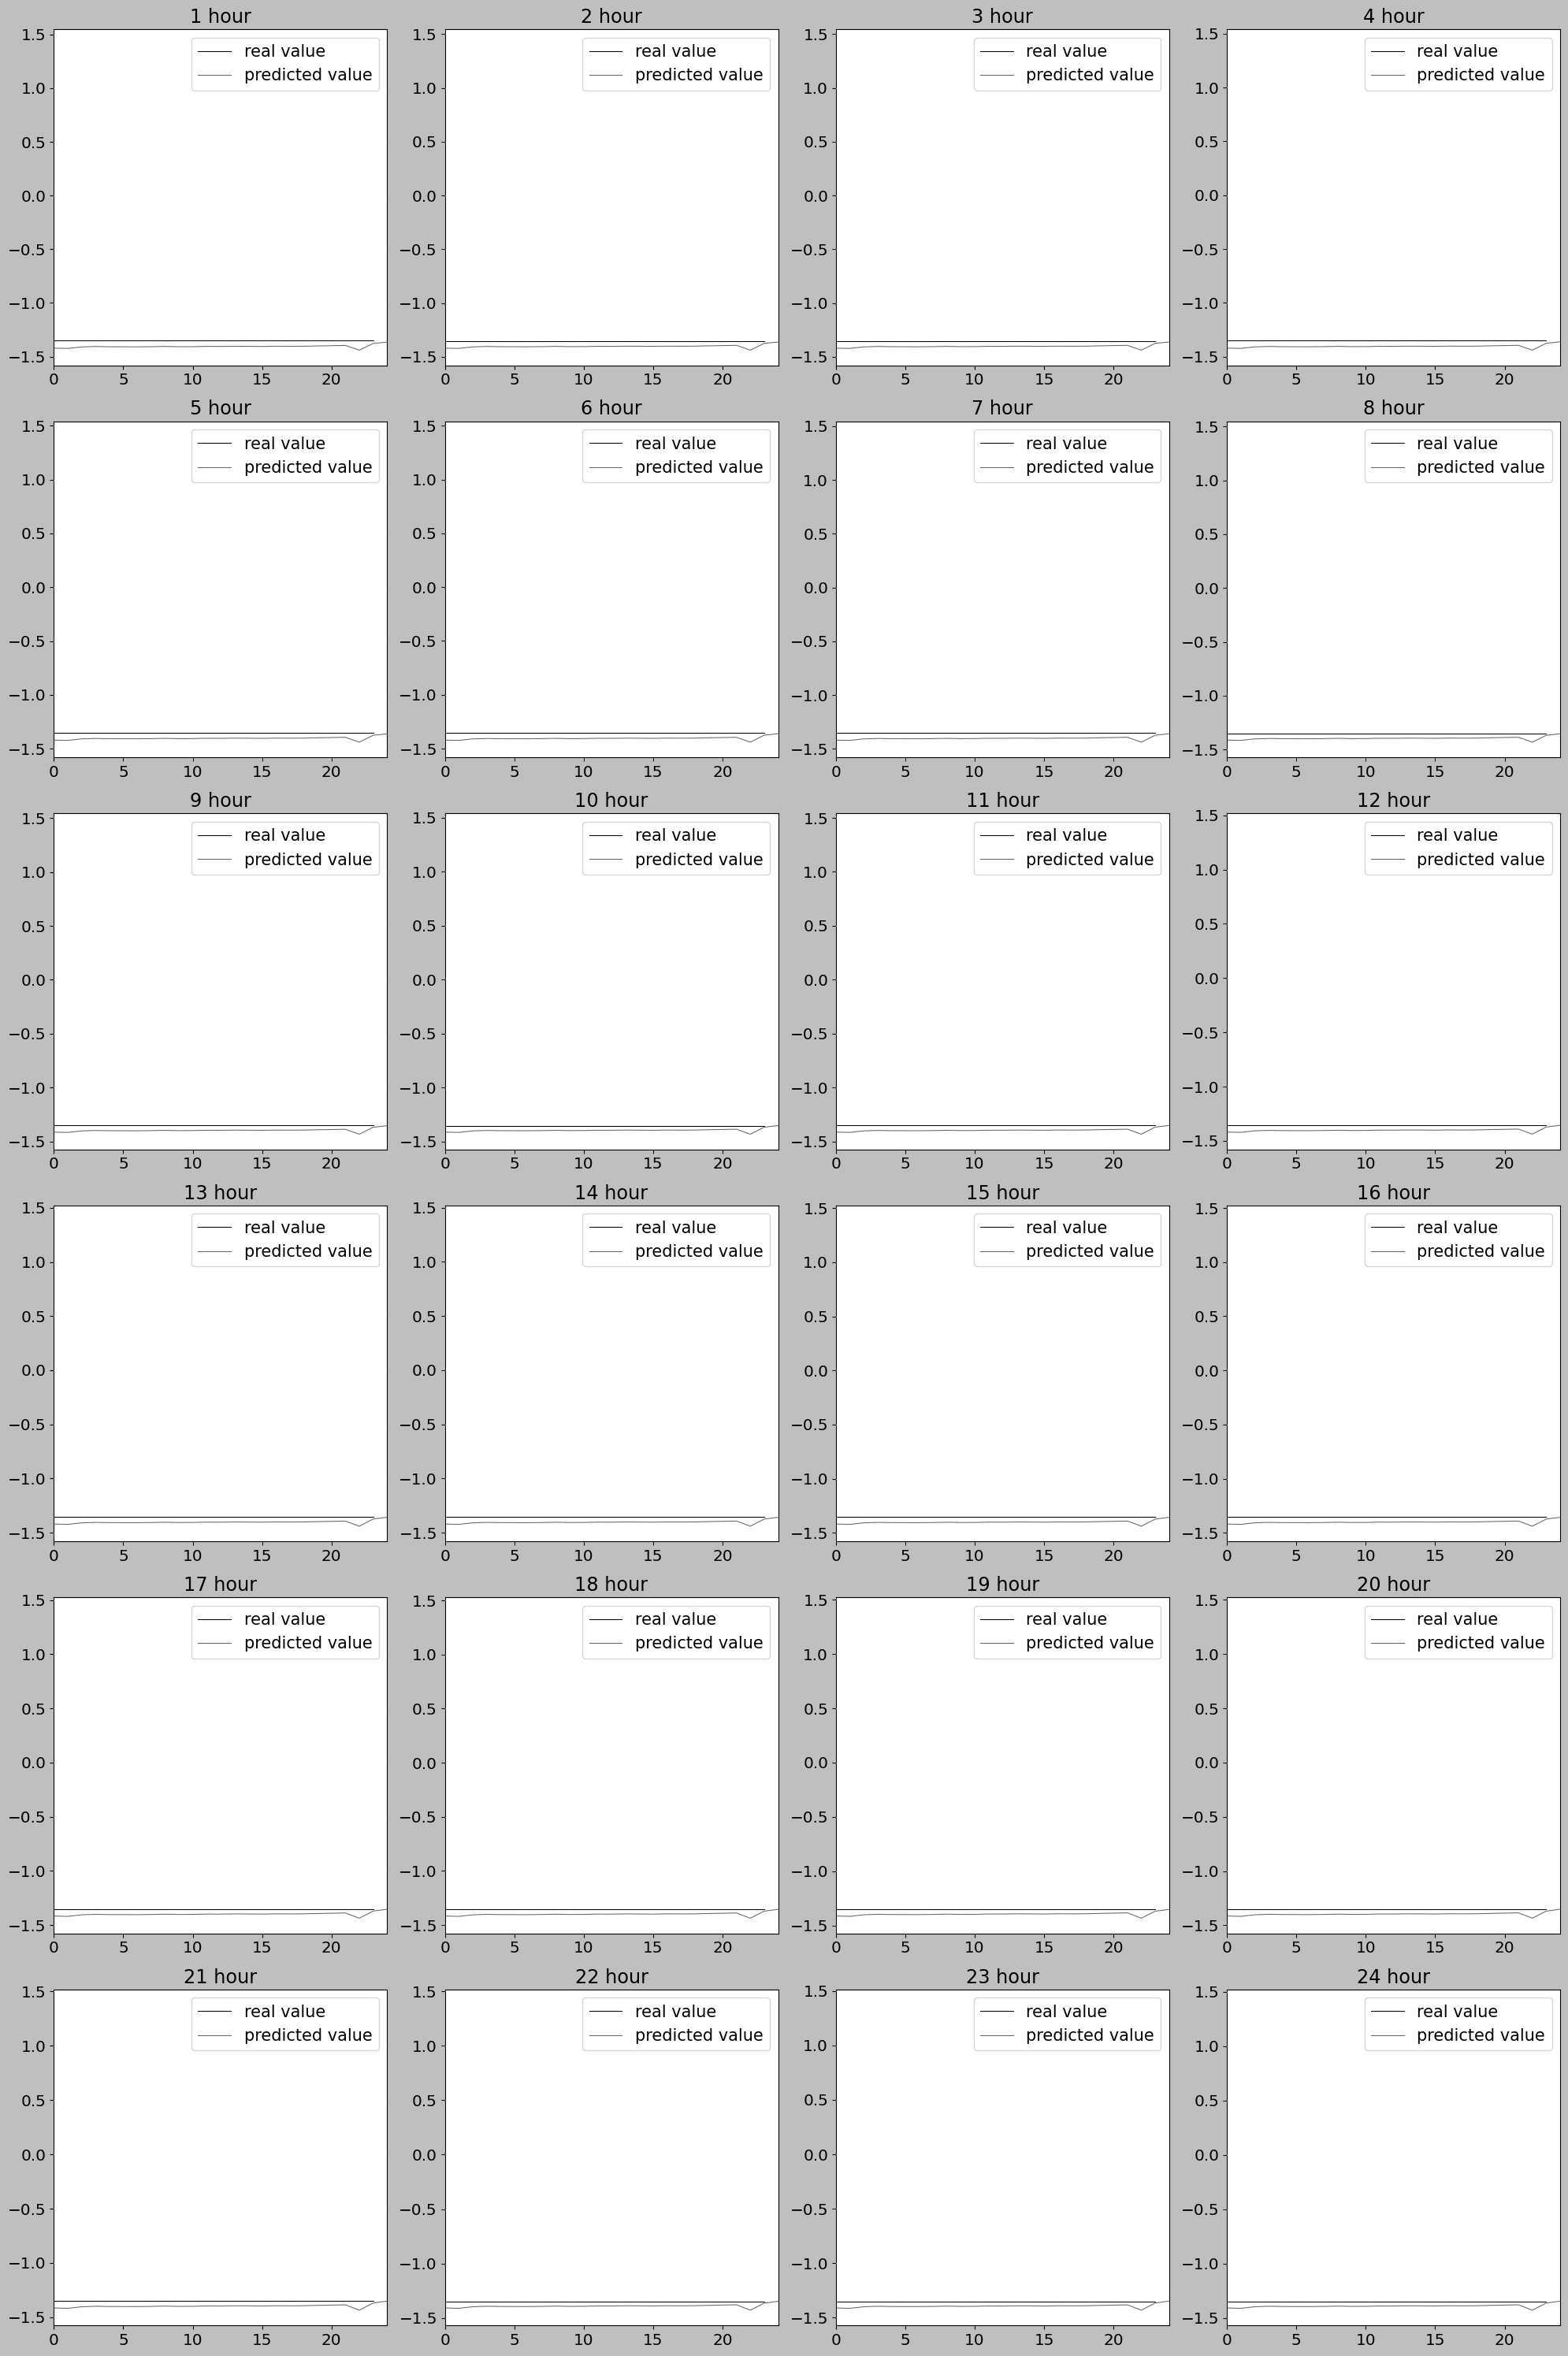

In [71]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(6, 4, figsize=(20, 30))  # Create a figure with 6 rows and 4 columns of subplots


for i in range(24):
    row = i // 4  # Calculate the row index for the subplot
    col = i % 4  # Calculate the column index for the subplot

    y_prede = y_prediction_array[:, i]
    draw = pd.concat([pd.DataFrame(yp[:24, i]), pd.DataFrame(y_prede)], axis=1)

    axs[row, col].plot(draw.iloc[:, 0])  # Plot y_test value in the corresponding subplot
    axs[row, col].plot(draw.iloc[:, 1])  # Plot predicted value in the corresponding subplot
    axs[row, col].legend(('real value', 'predicted value'), loc='upper right', fontsize='15')
    axs[row, col].set_xlim(0, len(yp[:24]))  # Set the x-axis limits for each subplot
    axs[row, col].set_title(f"{i+1} hour")  # Add a title to the subplot indicating the hour

plt.tight_layout()  # Adjust the spacing between subplots
plt.show()


In [72]:
df_predict_aggregate = pd.DataFrame(columns=['prediction_agg', 'actual'])
def aggregate_plot(y_actual, y_pred):
  y_mean_pred = []
  for j in range(23, -1, -1):
    sum=0
    for i in range(0, 24):
      if j-i>=0:
        sum += y_pred[i][j-i]
    y_mean_pred.append(sum/(j+1))
  y_mean_pred = list(reversed(y_mean_pred))
  df_predict_aggregate['prediction_agg'] = y_mean_pred
  df_predict_aggregate['actual'] = y_actual

  mape = mean_absolute_percentage_error(yp, y_prediction)
  print(mape)
  plt.plot(y_actual, marker='*', color='blue')
  plt.plot(y_mean_pred, marker='+', color ='red')
  plt.legend(('real value', 'predicted value'), loc='upper right', fontsize='15')
  plt.show()

In [73]:
df_predict_aggregate

,prediction_agg,actual


0.02973499083527124


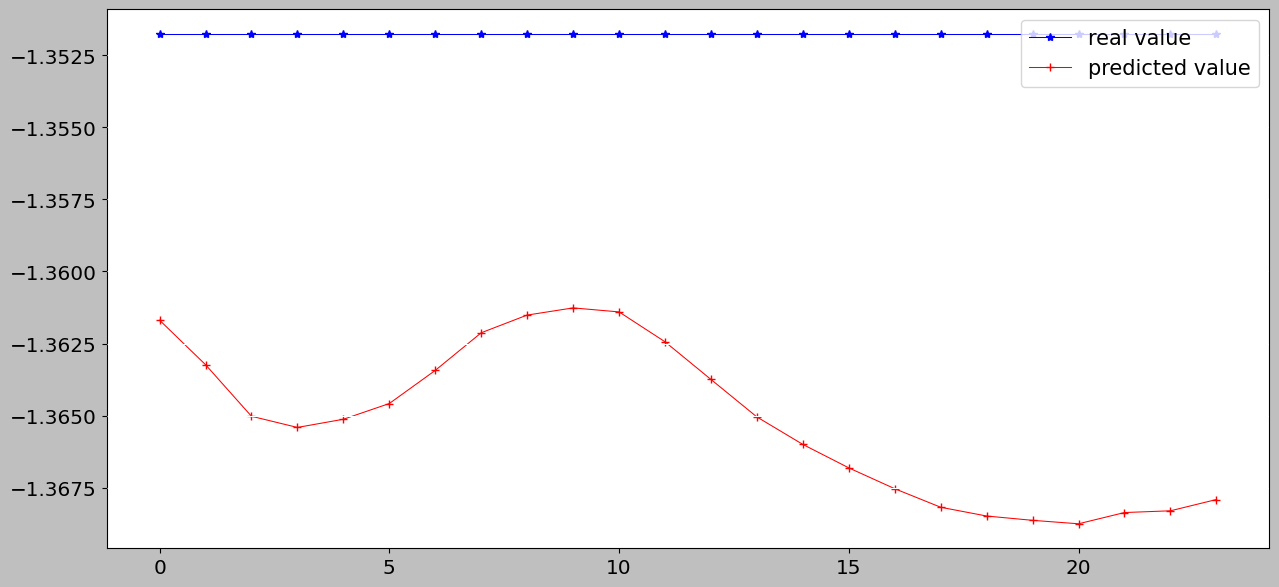

In [74]:
aggregate_plot(yp[240], y_prediction[240:264])